# Tutorial 1: Outlier p-values

This notebook demonstrates how to compute calibration-conditional conformal p-values for outlier detection, with the methods presented in the paper [1].

## 1. Setup

We begin by importing some standard libraries that will be useful for this example.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import random
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

random.seed(0)
np.random.seed(0)

/usr/lib/python3/dist-packages/tqdm/autonotebook/__init__.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  warn("Using `tqdm.autonotebook.tqdm` in notebook mode."


Now we import our custom library for this project, included in this repository.

In [2]:
import os
import sys
sys.path.append('../')

from cccpv.models import ToyModel
from cccpv.methods import ConformalPvalues
from cccpv.methods import calibrate_ccv

## 2. Data generation

We will generate 50-dimensional data from the same toy model as in the paper.

In [3]:
random_state = 2021

p = 50        # Number of features
a = 3         # Signal amplitude

model = ToyModel(p, a, random_state=random_state)

n = 2000      # Number of observations
purity = 0.9  # Proportion of inliers

X, is_outlier = model.sample(n, purity=purity)

print("Number of inliers: {}.".format(np.sum(is_outlier==0)))
print("Number of outliers: {}.".format(np.sum(is_outlier==1)))

Number of inliers: 1800.
Number of outliers: 200.


Since these data are high-dimensional, the difference between inliers and outliers will not be obvious to the nake eye. However, a PCA will help us visualize the difference between inliers and outliers.

In [4]:
## Perform nonlinear PCA on an independent set of clean data
from sklearn.decomposition import KernelPCA

X_clean, _ = model.sample(n, purity=1)

pca = KernelPCA(kernel="rbf", n_components=2, gamma=0.01)
pca.fit(X_clean)

## Apply the nonlinear PCA separately to the inliers and outliers
X_in = X[is_outlier==0]
pcs_in = pca.transform(X_in)

X_out = X[is_outlier==1]
pcs_out = pca.transform(X_out)

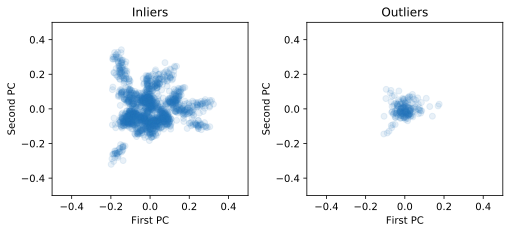

In [5]:
## Plot the PCA results
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].scatter(pcs_in[:,0], pcs_in[:,1], alpha=0.1)
axs[1].scatter(pcs_out[:,0], pcs_out[:,1], alpha=0.1)  
axs[0].set_xlim(-0.5,0.5)
axs[1].set_xlim(-0.5,0.5)
axs[0].set_ylim(-0.5,0.5)
axs[1].set_ylim(-0.5,0.5)
axs[0].set_xlabel("First PC")
axs[0].set_ylabel("Second PC")
axs[1].set_xlabel("First PC")
axs[1].set_ylabel("Second PC")
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
plt.show()

## 3. Training an outlier detection black-box algorithm

First, we split the clean data set into training and calibration subsets. Then, we fit a one-class classifier on the training data.

In [6]:
# Split data into training and calibration subsets
X_train, X_calib = train_test_split(X_clean, test_size=0.5, random_state=random_state) 

# Choose a one-class classifier algorithm
method_oneclass = "IForest"

# Initialize the one-class classifier
contamination = 0.001
contamination = min(max(contamination,0.004),0.1)
if method_oneclass == "SVM":
    classifier = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
if method_oneclass == "IForest":
    classifier = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
if method_oneclass == "Neighbors":
    classifier = LocalOutlierFactor(novelty=True, contamination=contamination)
    
# Fit the black-box one-class classifier
classifier.fit(X_train)

/usr/lib/python3/dist-packages/sklearn/ensemble/_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


IsolationForest(behaviour='new', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=2021, verbose=0, warm_start=False)

## 4. Computing marginal conformal p-values

Apply the one-class classifier to compute scores for the hold-out clean calibration data points.

In [7]:
# Compute scores on clean calibration data
scores_cal = classifier.score_samples(X_calib)

Apply the same classifier to compute scores for the test data points.

In [8]:
# Compute scores on test data
scores_test = classifier.score_samples(X)

Then, compute marginal conformal p-values for the test data.

In [9]:
scores_cal_mat = np.tile(scores_cal, (len(scores_test),1))
pvals_numerator = np.sum(scores_cal_mat <= scores_test.reshape(len(scores_test),1), 1)
pvals_marginal = (1.0+pvals_numerator)/(1.0+len(scores_cal))

Plot the distribution of p-values, separately for inliers and outliers.

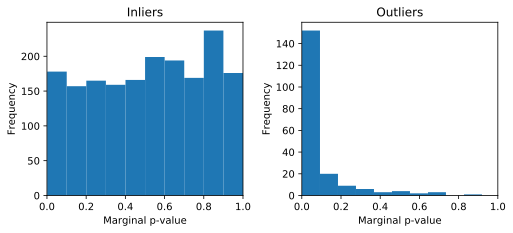

In [10]:
# Histogram of marginal p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_marginal[is_outlier==0])
axs[0].set_xlabel("Marginal p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_marginal[is_outlier==1])
axs[1].set_xlabel("Marginal p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.show()

## 5. Computing calibration-conditional conformal p-values

Now we apply Simes' method to obtain CCV p-values.

In [11]:
n_cal = X_calib.shape[0] # Number of calibration data points
delta = 0.1
pvals_ccv = calibrate_ccv(pvals_marginal, n_cal, delta=delta, method="Simes")

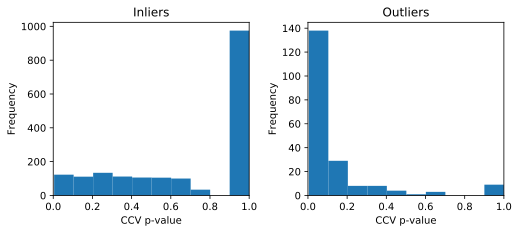

In [12]:
# Histogram of CCV p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

axs[0].hist(pvals_ccv[is_outlier==0])
axs[0].set_xlabel("CCV p-value")
axs[0].set_ylabel("Frequency")
axs[0].title.set_text('Inliers')
axs[0].set_xlim([0,1])

axs[1].hist(pvals_ccv[is_outlier==1])
axs[1].set_xlabel("CCV p-value")
axs[1].set_ylabel("Frequency")
axs[1].title.set_text('Outliers')
axs[1].set_xlim([0,1])

plt.show()

## 6. Numerical experiments

In this section, we compare the performance of marginal and CCV conformal p-values in a multiple testing problem, focusing on controlling the FDR below 10%.
The experimental setup is the same as that of the paper [1].

In [13]:
from utils_experiments import evaluate_all_methods

def run_experiment(model, method_oneclass, alpha=0.1, random_state=2021, purity=0.9, num_test=10):   
    # Sample training data
    data, _ = model.sample(n, random_state=random_state)

    # Initialize the one-class classifier
    contamination = 0.001
    contamination = min(max(contamination,0.004),0.1)
    if method_oneclass == "SVM":
        classifier = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
    if method_oneclass == "IForest":
        classifier = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
    if method_oneclass == "Neighbors":
        classifier = LocalOutlierFactor(novelty=True, contamination=contamination)
        
    # Calibrate the conformal classifier
    cc = ConformalPvalues(data, classifier, calib_size=0.5, random_state=random_state)

    # Evaluate performance on test data
    results = pd.DataFrame({})
    for test_index in range(num_test):
        # Sample test data
        random_state_new = random_state + 10000 * test_index
        data_test, is_outlier = model.sample(n, purity=purity, random_state=random_state_new)
        
        # Compute p-values on test data
        pvals_one_class = cc.predict(data_test, delta = 0.05, simes_kden=2)

        # Evaluate performance
        res = evaluate_all_methods(pvals_one_class, is_outlier, alpha=alpha)

        # Store results
        res['Amplitude'] = model.a
        res['Data-index'] = random_state
        res['Test-index'] = test_index
        results = pd.concat([results, res])
    
    return results

In [14]:
num_data = 100  # Number of data sets to simulate
num_test = 10  # Number of test sets to simulate for each data set
purity = 0.9   # Proportion of outliers in test data
a = 2.5        # Outlier signal strength

# Initialize data model
model = ToyModel(p, a)

# Choose a one-class classifier algorithm
method_oneclass = "SVM"

# Run all the experiments
results = pd.DataFrame({})
for train_index in tqdm(range(num_data)):
    res = run_experiment(model, method_oneclass, random_state=train_index, purity=purity, num_test=num_test)
    results = pd.concat([results, res])

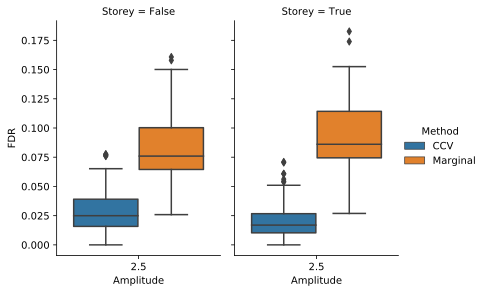

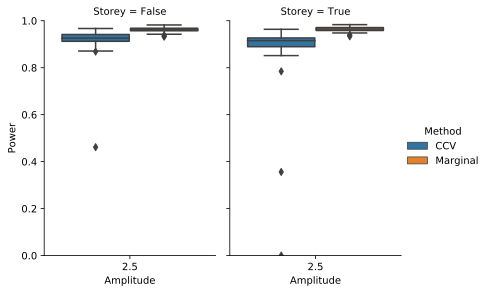

In [15]:
def plot_results(res, col_variable="Storey"):
    
    res = res.groupby(['Amplitude', 'Method', 'Pi0-true', 
                       'Alpha', 'Data-index', 'Storey']).mean().reset_index()
        
    ax = sns.catplot(x="Amplitude", y="FDR", hue="Method", col=col_variable, data=res,
                kind="box", height=4, aspect=.7)
    plt.show()

    ax = sns.catplot(x="Amplitude", y="Power", hue="Method", col=col_variable, data=res,
                    kind="box", height=4, aspect=.7)
    plt.ylim(0,1)
    plt.show()
    
plot_results(results)

## References

[1] Stephen Bates, Emmanuel Candes, Lihua Lei, Yaniv Romano, and Matteo Sesia. "Multiple Outlier Testing with Conformal p-values". arXiv preprint (2021).